In [64]:
import numpy as np
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier,GradientBoostingClassifier, AdaBoostClassifier
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import warnings
from sklearn.metrics import confusion_matrix
from sklearn import metrics
warnings.filterwarnings(action='ignore')
import matplotlib.pyplot as matplot
import seaborn as sns

In [107]:
# Loading data for each decade and appending a 'decade' column
datas = [pd.read_csv("/Users/raffimannarelli/Downloads/archive (7)/dataset-of-{}s.csv".format(decade)) for decade in ['60', '70', '80', '90', '00', '10']]
for i, decade in enumerate([1960, 1970, 1980, 1990, 2000, 2010]):
    datas[i]['decade'] = pd.Series(decade, index=datas[i].index)

# Combining all decade datasets, shuffling them, and resetting the index
data = pd.concat(datas, axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)

# Cleaning data: dropping unnecessary columns
data_load = data.copy()
data_load = data_load.drop(['track', 'artist', 'uri','instrumentalness','decade'], axis=1)

# Assuming df is your dataframe
#- target: The target variable for the track. It can be either '0' or '1'. '1' 
# implies that this song has featured in the weekly list (Issued by Billboards) of Hot-100 tracks in that decade at least once and is therefore a 'hit'. '0' Implies that the track is a 'flop'.
X = data_load.drop(columns=['target'])
y = data_load['target']

# Splitting data into training, validation, and test sets
X_inter, X_test, y_inter, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_inter, y_inter, test_size=0.25, random_state=42)

# Helper function to scale data and convert back to DataFrame
def scale_and_convert_to_df(data, scaler, fit=False):
    """Scale data using the provided scaler and convert back to DataFrame."""
    if fit:
        scaler.fit(data)
    return pd.DataFrame(scaler.transform(data), index=data.index, columns=data.columns)

# Initializing the scaler
scaler = StandardScaler()

# Scaling the training, validation, and test sets
X_train = scale_and_convert_to_df(X_train, scaler, fit=True)
X_val = scale_and_convert_to_df(X_val, scaler)
X_test = scale_and_convert_to_df(X_test, scaler)

# NOTE:

# We use two train_test_split calls to create a training set, a validation set, and a test set.
# The first split separates the data into an intermediate set (which will be further split into training and validation sets) and a test set.
# The second split breaks the intermediate set into the actual training and validation sets.
# This approach allows us to have distinct datasets for model training, hyperparameter tuning (validation), and final performance evaluation (test).
X_train.head()

data.describe()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,chorus_hit,sections,target,decade
count,41106.000000,41106.000000,41106.000000,41106.000000,41106.000000,41106.000000,41106.000000,41106.000000,41106.000000,41106.000000,41106.000000,4.110600e+04,41106.000000,41106.000000,41106.000000,41106.000000,41106.000000
mean,0.539695,0.579545,5.213594,-10.221525,0.693354,0.072960,0.364197,0.154416,0.201535,0.542440,119.338249,2.348776e+05,3.893689,40.106041,10.475673,0.500000,1982.775264
std,0.177821,0.252628,3.534977,5.311626,0.461107,0.086112,0.338913,0.303530,0.172959,0.267329,29.098845,1.189674e+05,0.423073,19.005515,4.871850,0.500006,17.491234
min,0.000000,0.000251,0.000000,-49.253000,0.000000,0.000000,0.000000,0.000000,0.013000,0.000000,0.000000,1.516800e+04,0.000000,0.000000,0.000000,0.000000,1960.000000
25%,0.420000,0.396000,2.000000,-12.816000,0.000000,0.033700,0.039400,0.000000,0.094000,0.330000,97.397000,1.729278e+05,4.000000,27.599792,8.000000,0.000000,1970.000000
50%,0.552000,0.601000,5.000000,-9.257000,1.000000,0.043400,0.258000,0.000120,0.132000,0.558000,117.565000,2.179070e+05,4.000000,35.850795,10.000000,0.500000,1980.000000
75%,0.669000,0.787000,8.000000,-6.374250,1.000000,0.069800,0.676000,0.061250,0.261000,0.768000,136.494000,2.667730e+05,4.000000,47.625615,12.000000,1.000000,2000.000000
max,0.988000,1.000000,11.000000,3.744000,1.000000,0.960000,0.996000,1.000000,0.999000,0.996000,241.423000,4.170227e+06,5.000000,433.182000,169.000000,1.000000,2010.000000


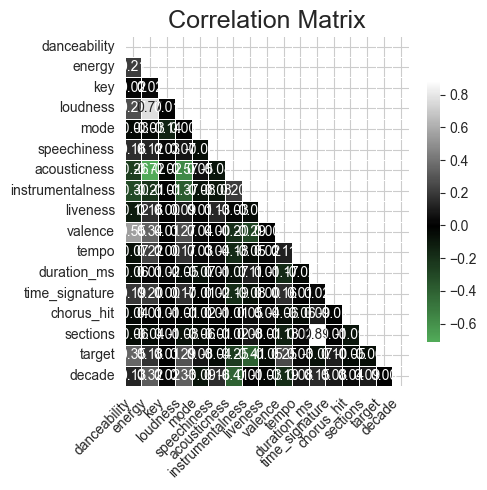

In [66]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap


correlation_matrix = data.corr()

# Create a custom colormap: 65D46E (green) -> 000000 (black) -> FFFFFF (white)
colors = ["#65D46E", "#000000", "#FFFFFF"]
cmap = LinearSegmentedColormap.from_list("custom_colormap", colors)

# Compute the mask for the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Enhance figure aesthetics
sns.set_style("whitegrid")

plt.figure(figsize=(5, 5))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap=cmap, center=0,
            mask=mask, linewidths=0.5, cbar_kws={"shrink": 0.75},
            annot_kws={"size": 10})

plt.xticks(rotation=45, ha="right", fontsize=10)  # Adjust x-tick label orientation and size
plt.yticks(fontsize=10)  # Adjust y-tick label size
plt.title('Correlation Matrix', fontsize=18)

plt.tight_layout()
plt.show()


In [101]:
numerical_columns = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'chorus_hit', 'sections']
for column in numerical_columns:
    plt.figure(figsize=(2, 2))
    sns.histplot(data[column], kde=True, bins=20)
    plt.title(f"Histogram for {column}")
    plt.show()

In [102]:
# Define a function to bin the data into quartiles
def bin_into_quartiles(df, column):
    quartiles = df[column].quantile([0.25, 0.5, 0.75]).values
    bins = [-np.inf, *quartiles, np.inf]
    labels = ['Q1', 'Q2', 'Q3', 'Q4']
    return pd.cut(df[column], bins=bins, labels=labels)

numerical_columns = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'chorus_hit', 'sections']

# Set style and context for a pretty plot
# Set style and context for a pretty plot
sns.set_style("whitegrid")
sns.set_context("talk")

# Custom color palette
palette = {1: "#65D46E", 0: "#000000"}

# Define a function to bin the data into quartiles with custom labels
def bin_into_custom_labels(df, column):
    quartiles = df[column].quantile([0.25, 0.5, 0.75]).values
    bins = [-np.inf, *quartiles, np.inf]
    labels = ['Low', 'Medium', 'High', 'Very High']
    return pd.cut(df[column], bins=bins, labels=labels)

numerical_columns = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'chorus_hit', 'sections']

# For each numerical column, bin the data and plot
for column in numerical_columns:
    data[f"{column}_bin"] = bin_into_custom_labels(data, column)
    
    # Plotting
    plt.figure(figsize=(12, 8))
    ax = sns.countplot(x=f"{column}_bin", hue="target", data=data, palette=palette)
    plt.title(f"Count of hits and non-hits based on {column}", fontsize=18)
    plt.xlabel(column, fontsize=16)
    plt.ylabel('Count', fontsize=16)
    
    # Relocate the legend outside of the plot
    plt.legend(title='Target', loc='center left', bbox_to_anchor=(1.0, 0.5), labels=['Flop', 'Hit'], fontsize=14, title_fontsize=14)
    
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
    # Add percentage on bars
    total = len(data)
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height() / total)
        x = p.get_x() + p.get_width() / 2
        y = p.get_height()
        ax.annotate(percentage, (x, y), ha='center', va='center', fontsize=12, color='gray', xytext=(0, 10), textcoords='offset points')
    
    plt.tight_layout()
    plt.show()


In [68]:
import pandas as pd

# Assuming your data is loaded into a variable named `data`
correlation_matrix = data.corr()

# Top N features positively correlated with the target
N = 5  # You can change this to any number you like
top_pos_correlations = correlation_matrix['target'].sort_values(ascending=False).head(N + 1)[1:]
print("Top", N, "features positively correlated with target:")
print(top_pos_correlations)

# Top N features negatively correlated with the target
top_neg_correlations = correlation_matrix['target'].sort_values().head(N)
print("\nTop", N, "features negatively correlated with target:")
print(top_neg_correlations)

# Pairs of features that are highly correlated with each other (greater than 0.8 or less than -0.8)
highly_correlated_pairs = []
for column in correlation_matrix.columns:
    for index in correlation_matrix.index:
        if (0.7 < correlation_matrix.at[index, column] < 1) or (-1 < correlation_matrix.at[index, column] < -0.7):
            pair = tuple(sorted((index, column)))
            if pair not in highly_correlated_pairs:
                highly_correlated_pairs.append(pair)

print("\nPairs of features that are highly correlated:")
for pair in highly_correlated_pairs:
    print(pair, correlation_matrix.at[pair[0], pair[1]])



Top 5 features positively correlated with target:
danceability      0.346097
loudness          0.286034
valence           0.251147
energy            0.177142
time_signature    0.104884
Name: target, dtype: float64

Top 5 features negatively correlated with target:
instrumentalness   -0.407638
acousticness       -0.246036
duration_ms        -0.073820
sections           -0.059997
liveness           -0.051445
Name: target, dtype: float64

Pairs of features that are highly correlated:
('energy', 'loudness') 0.7726281467232924
('acousticness', 'energy') -0.7150879117474258
('duration_ms', 'sections') 0.8889524737027972


In [69]:
from sklearn.metrics import accuracy_score
from sklearn.dummy import DummyClassifier
from sklearn.metrics import r2_score

# Create a dummy classifier
dummy_classifier = DummyClassifier(strategy='most_frequent')
dummy_classifier.fit(X_train, y_train)
baseline_predictions = dummy_classifier.predict(X_test)

# Baseline accuracy
baseline_accuracy = accuracy_score(y_test, baseline_predictions)
print(f"Baseline Accuracy: {baseline_accuracy:.4f}")

Baseline Accuracy: 0.4962


In [95]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb

# 1. Define models
models = {
    'XGBoost': xgb.XGBClassifier(),
    'RandomForest': RandomForestClassifier(),
    'LogisticRegression': LogisticRegression(max_iter=10000)
}

# 2. Define hyperparameter grids
param_grids = {
    'XGBoost': {
        'learning_rate': [0.01, 0.05, 0.1],
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 4, 5]
    },
    'RandomForest': {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10]
    },
    'LogisticRegression': {
        'C': [0.001, 0.01, 0.1, 1, 10],
        'penalty': ['l1', 'l2']
    }
}

# Splitting data and preprocessing were assumed to be done as in the previous step

best_estimators = {}

# 3. Grid search
for name, model in models.items():
    grid_search = GridSearchCV(model, param_grids[name], cv=5, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    best_estimators[name] = grid_search.best_estimator_
    print(f"{name}: Best Accuracy Score = {grid_search.best_score_:.4f}")
    print(f"Best Parameters: {grid_search.best_params_}\n")
# For each model
for name, best_estimator in best_estimators.items():
    predictions = best_estimator.predict(X_test)
    r2 = r2_score(y_test, predictions)
    print(f"{name} R2 Score: {r2:.4f}")
for name, best_estimator in best_estimators.items():
    train_predictions = best_estimator.predict(X_train)
    test_predictions = best_estimator.predict(X_test)

    train_accuracy = accuracy_score(y_train, train_predictions)
    test_accuracy = accuracy_score(y_test, test_predictions)

    print(f"{name} Training Accuracy: {train_accuracy:.4f}")
    print(f"{name} Test Accuracy: {test_accuracy:.4f}\n")


XGBoost: Best Accuracy Score = 0.7576
Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}

RandomForest: Best Accuracy Score = 0.7607
Best Parameters: {'max_depth': 30, 'min_samples_split': 2, 'n_estimators': 200}

LogisticRegression: Best Accuracy Score = 0.6942
Best Parameters: {'C': 0.01, 'penalty': 'l2'}

CatBoost: Best Accuracy Score = 0.7640
Best Parameters: {'depth': 8, 'iterations': 500, 'learning_rate': 0.05}

XGBoost R2 Score: 0.0386
RandomForest R2 Score: 0.0522
LogisticRegression R2 Score: -0.2406
CatBoost R2 Score: 0.0727
XGBoost Training Accuracy: 0.8050
XGBoost Test Accuracy: 0.7597

RandomForest Training Accuracy: 0.9996
RandomForest Test Accuracy: 0.7631

LogisticRegression Training Accuracy: 0.6949
LogisticRegression Test Accuracy: 0.6899

CatBoost Training Accuracy: 0.8592
CatBoost Test Accuracy: 0.7682



In [103]:
from scipy.optimize import minimize
# Assuming the XGBoost model is already trained
model = best_estimators['XGBoost']

def objective_function(features):
    # Convert numpy array to DataFrame with the right column names
    features_df = pd.DataFrame([features], columns=X_train.columns)
    
    # The optimizer tries to minimize, so we negate the prediction
    return -model.predict_proba(features_df)[0][1]

initial_guess = X_train.mean().values
bounds = [(X_train[col].min(), X_train[col].max()) for col in X_train.columns]


result = minimize(objective_function, initial_guess, bounds=bounds)
optimal_features = result.x


# Print the optimal features
for col, val in zip(X_train.columns, optimal_features):
    print(f"{col}: {val:.4f}")


danceability: 0.0000
energy: 0.0000
key: -0.0000
loudness: 0.0000
mode: 0.0000
speechiness: 0.0000
acousticness: -0.0000
liveness: -0.0000
valence: -0.0000
tempo: 0.0000
duration_ms: 0.0000
time_signature: -0.0000
chorus_hit: -0.0000
sections: -0.0000


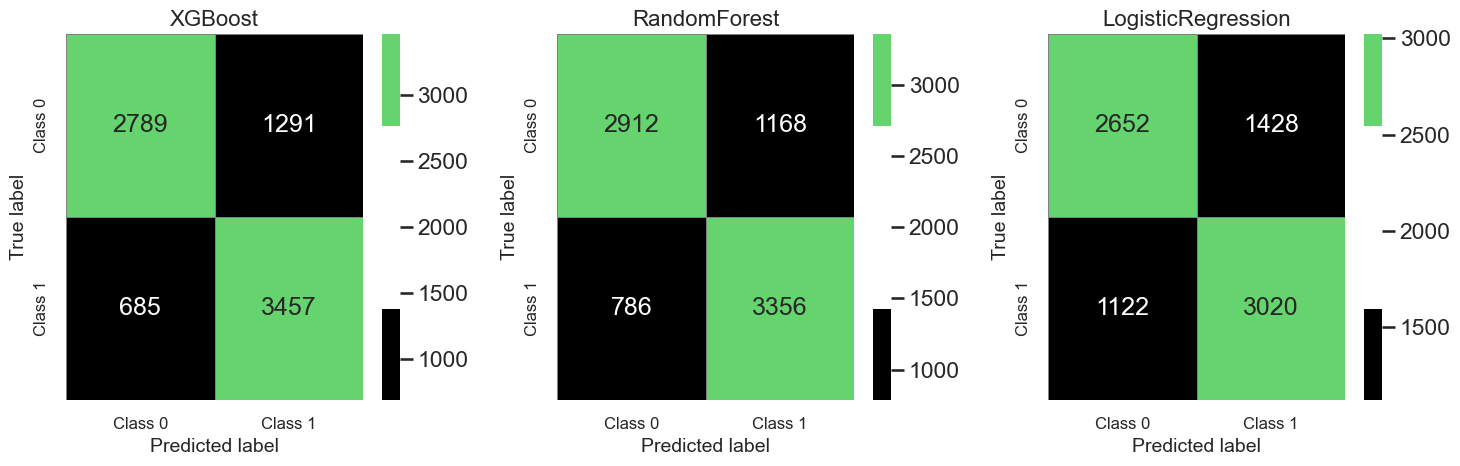

In [92]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from matplotlib.colors import ListedColormap

def plot_matrix(cm, title, ax):
    """Function to plot a confusion matrix using Seaborn."""
    
    # Define a custom color map
    colors = ["#000000", "#FFFFFF", "#FFFFFF", "#65D46E"]
    cmap = ListedColormap(sns.color_palette(colors).as_hex())

    sns.heatmap(cm, annot=True, fmt="g", cmap=cmap, ax=ax, linewidths=0.5, linecolor='gray')
    ax.set_title(title, fontsize=16)
    ax.set_xlabel('Predicted label', fontsize=14)
    ax.set_ylabel('True label', fontsize=14)
    ax.set_xticklabels(['Class 0', 'Class 1'], fontsize=12)
    ax.set_yticklabels(['Class 0', 'Class 1'], fontsize=12)
    ax.set_facecolor('#F5F5F5')  # To set the background color outside the heatmap

# Assuming the best_estimators dictionary is already populated
fig, axes = plt.subplots(1, len(best_estimators), figsize=(15, 5))

for (name, best_estimator), ax in zip(best_estimators.items(), axes):
    predictions = best_estimator.predict(X_test)
    cm = confusion_matrix(y_test, predictions)
    plot_matrix(cm, name, ax)

plt.tight_layout()
plt.show()



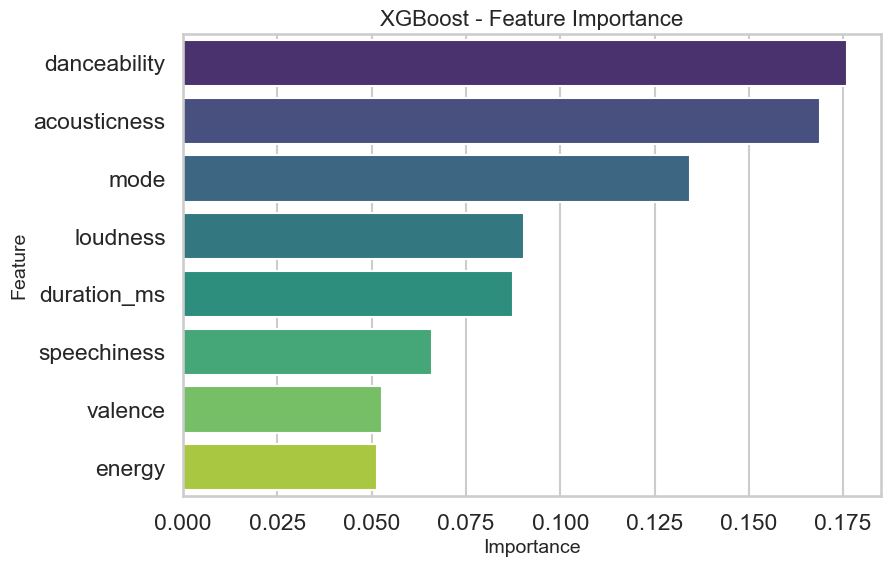

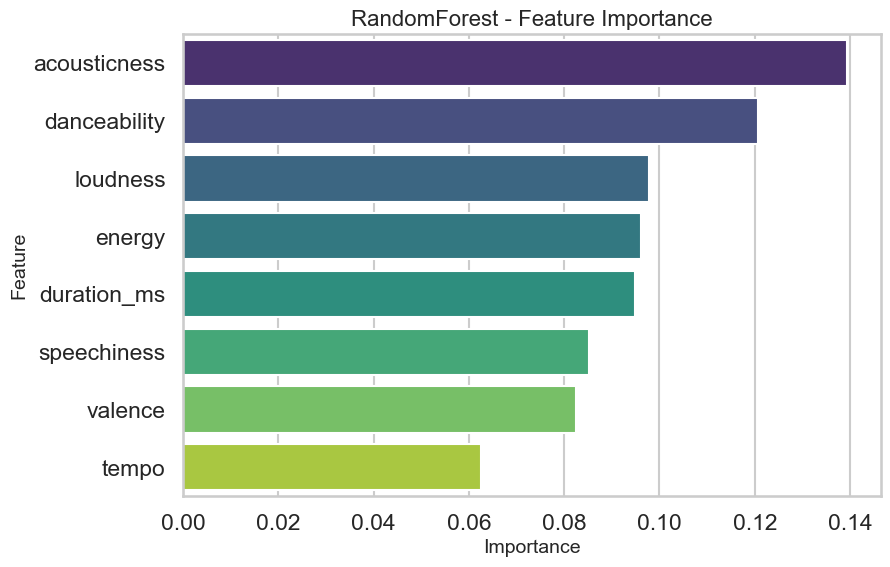

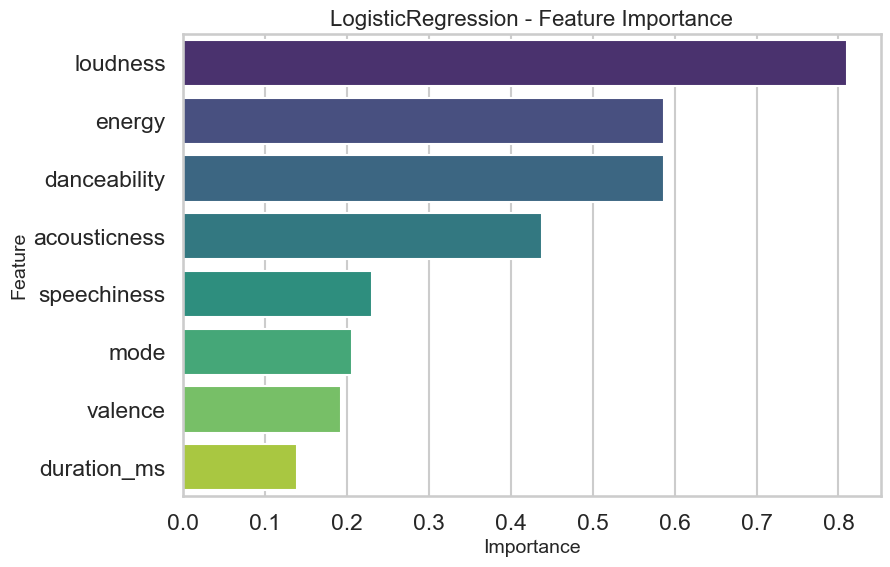

In [106]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_importance(estimator, title, feature_names):
    """
    Plots the feature importance for a given estimator.
    
    Args:
    - estimator: The trained model
    - title: The title of the plot
    - feature_names: Names of the features
    """
    
    try:
        # If feature importances are available (like for XGBoost & RandomForest)
        importance = estimator.feature_importances_
    except AttributeError:
        # For models like Logistic Regression
        importance = np.abs(estimator.coef_[0])
    
    # Sort the features based on importance
    sorted_idx = np.argsort(importance)[::-1]
    # Create a figure with proper size
    plt.figure(figsize=(9,6))
    
    # Use a colored bar plot for better visualization
    sns.barplot(x=importance[sorted_idx][:8], y=feature_names[sorted_idx][:8], palette="viridis")
    
    # Set labels and title
    plt.xlabel('Importance', fontsize=14)
    plt.ylabel('Feature', fontsize=14)
    plt.title(title + ' - Feature Importance', fontsize=16)
    
    # Display the plot
    plt.show()

# Set seaborn style
sns.set_style("whitegrid")

# Plot feature importance for models
for name, best_estimator in best_estimators.items():
    if name in ["XGBoost", "RandomForest", "LogisticRegression"]:
        plot_importance(best_estimator, name, X_train.columns)
